In [3]:
import sys
sys.path.append("..")

from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
from IPython.display import Audio
import numpy as np
import pandas as pd
import pickle
import yaml

from lib import utils
from lib.notebooks import plot_groups_metrics
from communicative_agent import CommunicativeAgent

In [4]:
NB_TRAINING = 5
JERK_LOSS_WEIGHTS = [0, 0.15]

In [17]:
metrics_name = ["inverse_model_jerk", "inverse_model_repetition_error"]
groups_metrics = { metric_name: {} for metric_name in metrics_name }

final_configs = utils.read_yaml_file("communicative_final_configs.yaml")
final_quantizer_configs = utils.read_yaml_file("../quantizer/quantizer_final_configs.yaml")

for config_name, config in final_configs.items():
    quantizer_name = config_name.split("-")[0]
    quantizer_config = final_quantizer_configs["%s-cepstrum" % quantizer_name]

    for i_training in range(NB_TRAINING):
        quantizer_config["dataset"]["datasplit_seed"] = i_training
        quantizer_signature = utils.get_variable_signature(quantizer_config)

        for jerk_loss_weight in JERK_LOSS_WEIGHTS:
            config["sound_quantizer"]["name"] = "%s-%s" % (quantizer_signature, i_training)
            config["training"]["jerk_loss_weight"] = jerk_loss_weight

            agent_group = "%s jerk=%s" % (config_name, jerk_loss_weight)
            
            agent_signature = utils.get_variable_signature(config)
            agent_name = "%s-%s" % (agent_signature, i_training)
            agent_path = "../out/communicative_agent/%s" % agent_name
            with open("%s/metrics.pickle" % agent_path, "rb") as f:
                metrics = pickle.load(f)
            
            final_loss_index = np.argmin(metrics["validation"]["inverse_model_repetition_error"])
            
            for metric_name in metrics_name:
                if agent_group not in groups_metrics[metric_name]:
                    groups_metrics[metric_name][agent_group] = []
                agent_metric = metrics["test"][metric_name][final_loss_index]
                groups_metrics[metric_name][agent_group].append(agent_metric)

pb2007 jerk=0 0.010959197471051344
pb2007 jerk=0.15 2866.905648367746
pb2007-synth_as_direct jerk=0 0.011766829973618899
pb2007-synth_as_direct jerk=0.15 545.5332933698381


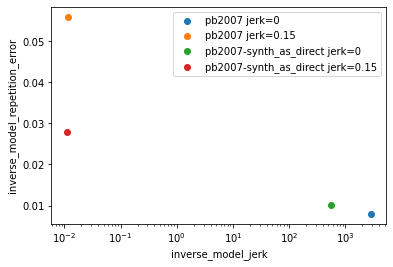

In [24]:
plot_metrics = ["inverse_model_jerk", "inverse_model_repetition_error"]
plot_scales = ["log", "linear"]

plt.figure()
ax = plt.subplot()
ax.set_xlabel(plot_metrics[0])
ax.set_ylabel(plot_metrics[1])
ax.set_xscale(plot_scales[0])
ax.set_yscale(plot_scales[1])

groups_name = groups_metrics[plot_metrics[0]].keys()
for group_name in groups_name:
    print(group_name, x)
    x = np.mean(groups_metrics[plot_metrics[0]][group_name])
    y = np.mean(groups_metrics[plot_metrics[1]][group_name])
    ax.scatter(x, y, label=group_name)
ax.legend()
plt.show()